In [5]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

In [6]:
@jit(nopython = True)
def init_wave_func(k0_prime, N, n_cicles):
    psi = np.zeros((n_cicles, N), dtype = np.cdouble)
    i = 1
    while(i < N-1):
        psi[0, i] = np.exp(1j*k0_prime*i)*np.exp((-8*(4*i-N)**2)/N**2)
        i += 1
    return psi

@jit(nopython = True)
def init_potential(k0_prime, lamb, N):
    V_prime = np.zeros(N)
    i = int(2*N/5)
    while(i < 3*N/5):
        V_prime[i] = lamb*k0_prime**2
        i += 1
    return V_prime

@jit(nopython = True)
def compute_norm(psi, n):
    return np.linalg.norm(psi[n])
    
@jit(nopython = True)
def compute_alpha(V_prime, s_prime, N):
    alpha = np.zeros(N, dtype = np.cdouble)
    i = N-1
    while(i > 0):
        alpha[i-1] = -1/(2+(2j/s_prime)-V_prime[i]+alpha[i])
        i -= 1
    return alpha

@jit(nopython = True)
def compute_beta(psi, alpha, V_prime, s_prime, N, n):
    b = np.zeros(N, dtype = np.cdouble)
    beta = np.zeros(N, dtype = np.cdouble)
    i = 0
    while(i < N):
        b[i] = 4j*psi[n][i]/s_prime
        i +=1
    i = N-1
    while(i > 0):
        beta[i-1] = (b[i]-beta[i])/(2+(2j/s_prime)-V_prime[i]+alpha[i])
        i -= 1  
    return beta     

@jit(nopython = True)
def compute_chi(alpha, beta, N):
    chi = np.zeros(N, dtype = np.cdouble)
    i = 0
    while(i < N):
        chi[i+1] = alpha[i]*chi[i] + beta[i]
        i += 1
    return chi

@jit(nopython = True)
def compute_wave_func(psi, chi, n):
    psi[n+1] = chi - psi[n]
    return psi

@jit(nopython = True)
def iterative_process(n_cicles, N, s, h, lamb):
    s_prime = s/h**2
    k0_prime = 2*np.pi*2/N

    psi = init_wave_func(k0_prime, N, n_cicles)
    V_prime = init_potential(k0_prime, lamb, N)
    alpha = compute_alpha(V_prime, s_prime, N)

    norm = np.zeros(n_cicles)

    i = 0
    while(i < n_cicles-1):
        beta = compute_beta(psi, alpha, V_prime, s_prime, N, i)
        chi = compute_chi(alpha, beta, N)
        psi = compute_wave_func(psi, chi, i)
        norm[i] = compute_norm(psi, i)
        i += 1
    return psi, norm

@jit(nopython = True)
def prob_density(psi, N, n_cicles):
    prob = np.zeros((n_cicles, N))
    i = 0
    while(i < n_cicles):
        prob[i] = np.absolute(psi[i])
        i += 1
    return prob


In [7]:
N= 100
n_cicles = 10000
s = 0.0001
h = 0.01
lamb = 0.3

psi, norm = iterative_process(n_cicles, N, s, h, lamb)
prob = prob_density(psi, N, n_cicles)
print(prob)

[[0.00000000e+00 6.28107015e-04 1.14631824e-03 ... 1.52160804e-29
  2.37822114e-30 0.00000000e+00]
 [0.00000000e+00 5.60111801e-04 1.14823763e-03 ... 8.84787099e-28
  3.16254433e-28 1.12013112e-28]
 [0.00000000e+00 4.79125707e-04 1.12348152e-03 ... 4.53626130e-26
  1.63536493e-26 5.93748677e-27]
 ...
 [0.00000000e+00 3.90851884e-02 8.13354426e-02 ... 2.57731208e-01
  1.78422505e-01 9.12368599e-02]
 [0.00000000e+00 3.93607286e-02 8.18649660e-02 ... 2.56732670e-01
  1.77766752e-01 9.09253249e-02]
 [0.00000000e+00 3.96944865e-02 8.24659824e-02 ... 2.55739788e-01
  1.77119980e-01 9.06038396e-02]]


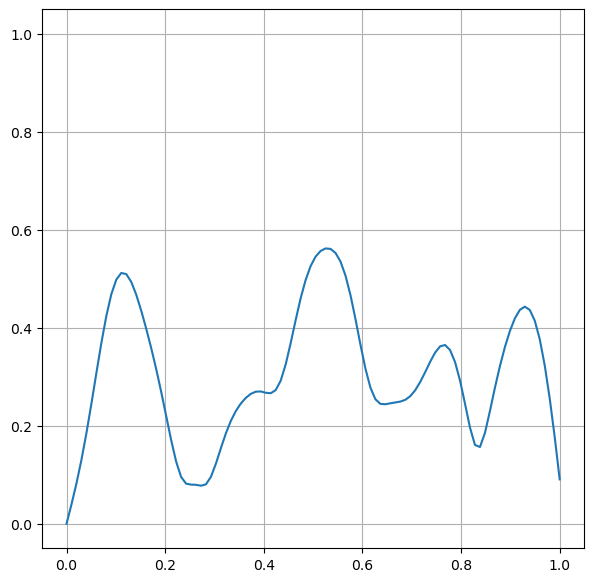

In [8]:
fig=plt.figure(figsize=(7,7)) #Size of the plot
ax=fig.add_subplot(111)

x = np.linspace(0, 1, N)
line, = ax.plot(x, prob[0])
plt.grid()

def animate (i, prob, line):
    line.set_ydata(prob[i])
    return line,

FFwriter = FFMpegWriter(fps=60, extra_args=['-vcodec', 'libx264'])

animation = FuncAnimation(fig, animate, fargs=(prob, line), frames=n_cicles, blit=True, interval=10)

animation.save("{}.mp4".format(f"schrodinger"), dpi=100, writer = FFwriter)